# Main CNN model for bat call classification

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# dont use gpu [for M1/M2 Metal, cause it cant handle Dropout Layers too well], comment out if you want to use GPU
physical_devices = tf.config.list_physical_devices('GPU')  # this +
tf.config.set_visible_devices(physical_devices[1:], 'GPU') # this fixes the above mentioned bug with the Droputlayers. idfk why
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
import gc
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import cv2

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
adasyn = ADASYN()

X, y = resample(adasyn)
#X, y = data['data'], data['Species']
#X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

ADASYN():  5    2126
0    2104
4    2081
3    2044
2    2036
1    2032
Name: count, dtype: Int64


In [3]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1


X = X / 255.
X = X.reshape((-1,) + image_shape)

# denoise
#autoencoder = tf.keras.saving.load_model('./ae_files/denoise_autoencoder_cnn.keras')
#X = autoencoder.predict(X)

Image has shape (65, 100, 3)


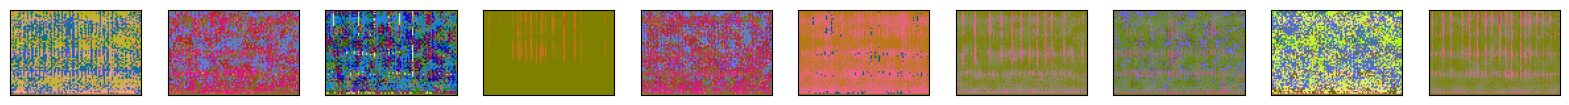

In [4]:
# show sample of generated images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    if image_shape[2]==1:
        plt.imshow((X[i]*255.).astype('uint8'),cmap='inferno',vmin=0, vmax=255) # for grayscale images
    elif image_shape[2]==4 or image_shape[2]==3:
        plt.imshow(cv2.cvtColor((X[i]*255.).astype('uint8'),cv2.COLOR_BGR2RGB)) # for rgb images
    
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [5]:
kfold = KFold(n_splits=2, shuffle=True) # orig n=10 splits

tf.keras.utils.set_random_seed(1)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.2 #or 0.3 # https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets interessant bzgl oberfitting
weight_decay_alpha = 0.01 # or 0.015

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape,name="aaa"))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    #model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

In [7]:
def fit_model(model, X_train, y_train, worker=8):
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        workers=worker, # workers are number of cores
        callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
        validation_split=0.2,
        verbose=1)

    return history

In [8]:
end_step = np.ceil(X.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
    # In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)}

model = create_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

In [9]:
# for confusion_matrix
true_labels = list()
pred_labels = list()
train_accuracies = list()
test_accuracies = list()
val_accuracies = list()
train_losses = list()
val_losses = list()
test_losses = list()

for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = fit_model(model, X_train, y_train)

    # for confusion matrix
    predictions = np.argmax(model.predict(X_test), axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # for accuracy curves
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])

    # for loss curves
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

    loss, accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(accuracy)
    test_losses.append(loss)

Epoch 1/200
156/156 [==============================] - 8s 35ms/step - loss: 7.6709 - accuracy: 0.3138 - val_loss: 5.6114 - val_accuracy: 0.1706
Epoch 2/200
156/156 [==============================] - 5s 34ms/step - loss: 4.1450 - accuracy: 0.3657 - val_loss: 4.2109 - val_accuracy: 0.1706
Epoch 3/200
156/156 [==============================] - 5s 35ms/step - loss: 3.0363 - accuracy: 0.4444 - val_loss: 3.3913 - val_accuracy: 0.2767
Epoch 4/200
156/156 [==============================] - 6s 37ms/step - loss: 2.4738 - accuracy: 0.5066 - val_loss: 2.8654 - val_accuracy: 0.3741
Epoch 5/200
156/156 [==============================] - 6s 38ms/step - loss: 2.1977 - accuracy: 0.5574 - val_loss: 2.6931 - val_accuracy: 0.3781
Epoch 6/200
156/156 [==============================] - 6s 36ms/step - loss: 1.9521 - accuracy: 0.6025 - val_loss: 1.8561 - val_accuracy: 0.6356
Epoch 7/200
156/156 [==============================] - 6s 37ms/step - loss: 1.8019 - accuracy: 0.6341 - val_loss: 2.0586 - val_accuracy:

In [10]:
# VGG19 als Vergleich zu unserem
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
#epochs = 200
#batch_size = 32
#
#vgg19_test_accuracies = list()
#
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(65, 100, 3))
#
## Freeze the convolutional base
#for layer in base_model.layers:
#    layer.trainable = False
#
#model = Sequential()
#model.add(base_model)
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(6, activation='softmax'))
#
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#
#for train_indezes, test_indezes in kfold.split(X, y):
#    K.clear_session()
#    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
#    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
#    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)
#    _, accuracy = model.evaluate(X_test, y_test)
#    vgg19_test_accuracies.append(accuracy)

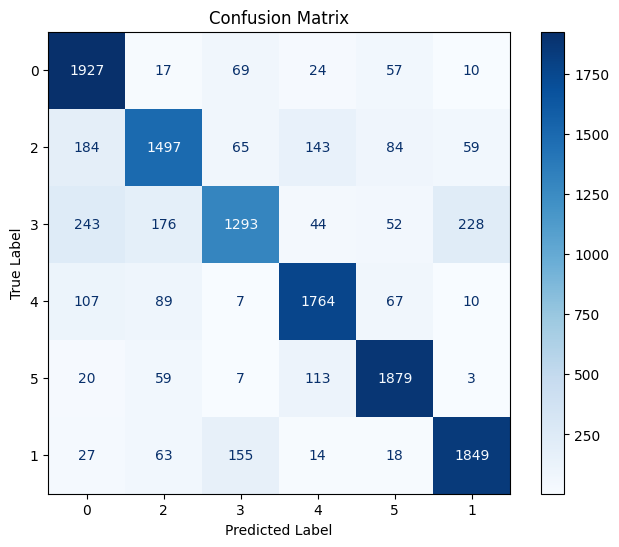

In [11]:
confusion_matrix = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

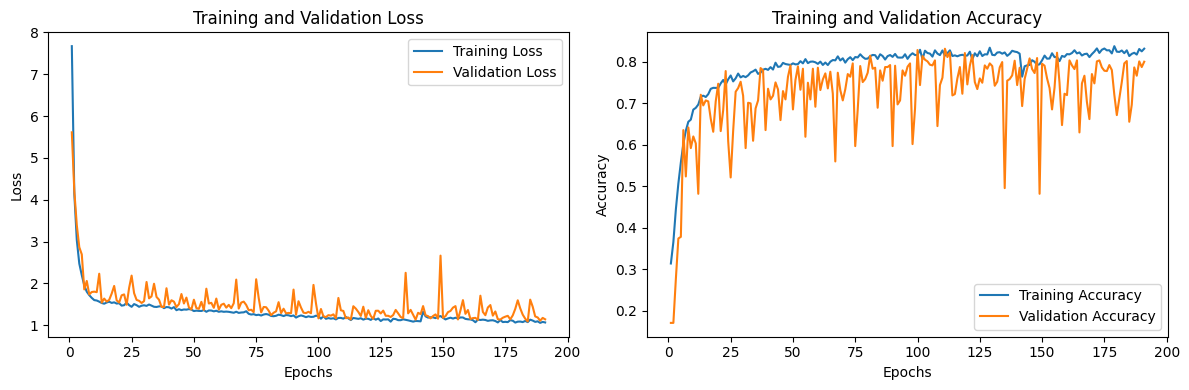

In [12]:
# Plotting the training and validation curves
epochs = len(train_losses)
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()

In [13]:
print(f"Avg. Test accuracy: {sum(test_accuracies) / len(test_accuracies)}")
print(f"Best Test Accuracy: {max(test_accuracies)}")
print(f"Test loss: {sum(test_losses) / len(test_losses)}")


#print(f"VGG19 test accuracy: {sum(vgg19_test_accuracies) / len(vgg19_test_accuracies)}")

Avg. Test accuracy: 0.821781724691391
Best Test Accuracy: 0.8275917768478394
Test loss: 1.1554921865463257
